# Cars

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [2]:
tsensor.__version__

'0.1b7'

In [3]:
df_cars = pd.read_csv("../data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [4]:
def show(m, b, X=df_cars.WGT, Y=df_cars.MPG):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, Y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    plt.show()

## Brute force linear model

In [5]:
# brute force model parameter space search (m,b)
best = (1e100,0,0)
for m in np.linspace(-0.005,-.01,num=5):
    for b in np.linspace(42,47,num=5):
        y = m * df_cars.WGT + b
        mse = np.mean((y - df_cars.MPG)**2)
        if mse < best[0]:
            best = (mse,m,b)
        print(f"{m:4.3f},{b:4.3f} => MSE {mse:.1f}")
m = best[1]
b = best[2]
print(f"BEST {m:.3f}*x + {b:.3f}")

-0.005,42.000 => MSE 37.2
-0.005,43.250 => MSE 47.9
-0.005,44.500 => MSE 61.7
-0.005,45.750 => MSE 78.7
-0.005,47.000 => MSE 98.8
-0.006,42.000 => MSE 20.1
-0.006,43.250 => MSE 21.5
-0.006,44.500 => MSE 26.1
-0.006,45.750 => MSE 33.7
-0.006,47.000 => MSE 44.5
-0.007,42.000 => MSE 33.0
-0.007,43.250 => MSE 25.1
-0.007,44.500 => MSE 20.3
-0.007,45.750 => MSE 18.7
-0.007,47.000 => MSE 20.2
-0.009,42.000 => MSE 75.8
-0.009,43.250 => MSE 58.6
-0.009,44.500 => MSE 44.5
-0.009,45.750 => MSE 33.6
-0.009,47.000 => MSE 25.8
-0.010,42.000 => MSE 148.6
-0.010,43.250 => MSE 122.1
-0.010,44.500 => MSE 98.7
-0.010,45.750 => MSE 78.5
-0.010,47.000 => MSE 61.4
BEST -0.007*x + 45.750


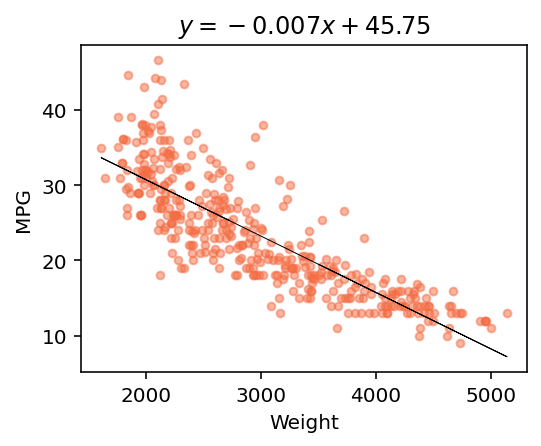

In [6]:
show(m, b)

## Linear model with numpy, one learning rate

### Manual gradient computation of loss function

use the sum, ignoring 1/n constant.

$$
loss = \sum_i^n E^2 \text{ where } E = \hat{y} - y = mx + b - y
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial m} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial m}\\
 & = & \sum_i^n E x\\
\end{array}
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial b} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial b}\\
 & = & \sum_i^n E\\
\end{array}
$$

Loss function is a saddle like this:

<img src="images/2d-loss.png" width="200">

Epoch     0 0.37,45.00: MSE loss  1382868.259 MAE  1130.85
Epoch    10 -0.01,45.00: MSE loss       18.788 MAE     3.26
LAST        -0.01,45.00: MSE loss       18.788 MAE     3.26


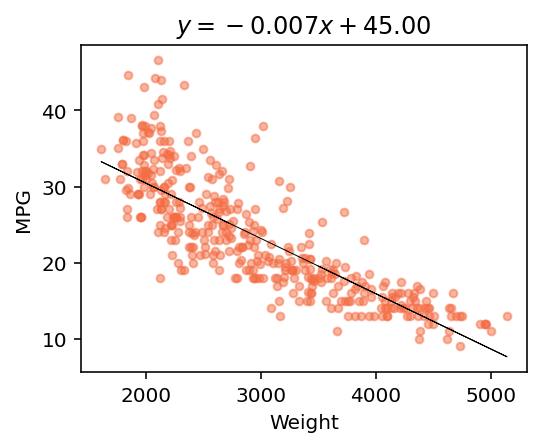

In [7]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
Y = np.array(df_cars.MPG).reshape(n,1)

# Randomly initialize weights
m = np.random.random(size=1)[0]
b = 45.0 # get it very close to an answer
learning_rate = .0000000003
nepochs=10
for epoch in range(nepochs+1):
    y_pred = m * X + b
    E = y_pred - Y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - Y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Compute the gradient of loss with respect to m, b
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b)

## Linear model with standardized/normalized variables

Standardizing variables to be mean centered and with standard deviation one, improves convergence speed. Previously we had to choose a `b` that was very close to the answer.

### Standardize

The old but very useful article [Efficient BackProp by LeCun et al](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), describes why we need to standardize our X variables. I'm under the impression that getting all of the variances to 1.0 or at least similar, means we don't need learning rates per dimension (variable). The article indicates that we want the zero mean because "*any shift of the average input away from zero will bias the updates in a particular direction and thus slow down learning.*"  Consider the input layer to a network. We saw above that the derivative of the loss with respect to the $m$ slope parameter is the error, $E = y-\hat{y}$, times the $x_i$ input for variable $i$. LeCun points out that, if all inputs are positive, the $sign(E)$ dictates the direction we update the $m$ slopes. "*... these weights [$m$] can only all decrease or all increase together for a given input pattern. Thus, if a weight vector must change direction it can only do so by zigzagging which is inefficient and thus very slow.*"

In [8]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
X = (X-np.mean(X))/np.std(X)
Y = np.array(df_cars.MPG).reshape(n,1)

0.1713962103254495 0.9387401115736819
Epoch     0 0.17,0.94: MSE loss      569.589 MAE    22.51
Epoch    10 -5.74,20.91: MSE loss       25.694 MAE     3.67
Epoch    20 -6.40,23.16: MSE loss       18.766 MAE     3.26
Epoch    30 -6.48,23.41: MSE loss       18.678 MAE     3.28
Epoch    40 -6.49,23.44: MSE loss       18.677 MAE     3.28
Epoch    50 -6.49,23.45: MSE loss       18.677 MAE     3.28
LAST        -6.49,23.45: MSE loss       18.677 MAE     3.28


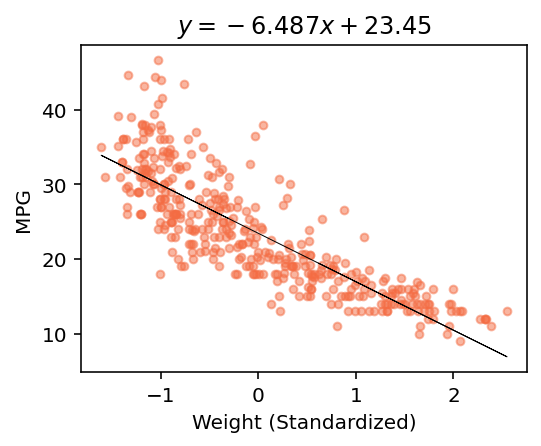

In [9]:
# Randomly initialize weights
m = np.random.random(size=1)[0]
b = np.random.random(size=1)[0]
print(m,b)
learning_rate = .0005 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=50
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    E = y_pred - Y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - Y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b, X=X, Y=df_cars.MPG)

## Linear model with pytorch

In [10]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).reshape(n,1).float()
X = (X-torch.mean(X))/torch.std(X)
Y = torch.tensor(df_cars.MPG).reshape(n,1)

Epoch     0 -0.11,-0.65: MSE loss      640.193 MAE    24.10
Epoch    10 -5.81,20.86: MSE loss       25.848 MAE     3.70
Epoch    20 -6.42,23.17: MSE loss       18.759 MAE     3.26
Epoch    30 -6.49,23.42: MSE loss       18.678 MAE     3.28
LAST        -6.49,23.42: MSE loss       18.678 MAE     3.28


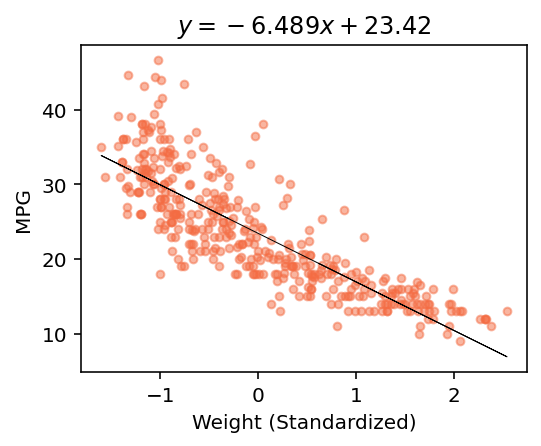

In [11]:
# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True) # too far away from correct answer for one learning rate
learning_rate = .1 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=30
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    with torch.no_grad():
        m -= learning_rate * m.grad
        b -= learning_rate * b.grad
    
#     print(m.detach().item(), b.detach().item())
    # Zero the gradients
    m.grad.zero_()
    b.grad.zero_()

m = m.detach().item()
b = b.detach().item()
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b, X=X, Y=df_cars.MPG)

## Linear model with pytorch using Adam optimizer

Epoch     0 -0.26,-0.28: MSE loss      620.399 MAE    23.73
Epoch    10 -8.42,18.60: MSE loss       45.891 MAE     5.47
Epoch    20 -5.32,28.75: MSE loss       48.165 MAE     6.18
Epoch    30 -7.18,26.49: MSE loss       28.400 MAE     4.40
Epoch    40 -6.17,21.99: MSE loss       20.901 MAE     3.36
Epoch    50 -6.57,22.23: MSE loss       20.151 MAE     3.37
Epoch    60 -6.57,24.02: MSE loss       19.014 MAE     3.36
Epoch    70 -6.38,23.81: MSE loss       18.820 MAE     3.32
LAST       -6.37,23.72: MSE loss       18.820 MAE     3.32


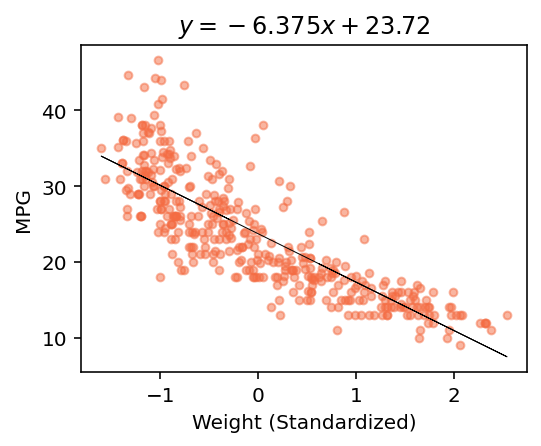

In [12]:
# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True)

learning_rate = 2
optimizer = torch.optim.Adam([m,b], lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients of w1, w2, ... with respect to loss
    optimizer.zero_grad()
    loss.backward() # autograd computes w1.grad, b1.grad, ...
    optimizer.step()
m = m.detach().item()
b = b.detach().item()
print(f"LAST       {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

show(m, b, X=X, Y=df_cars.MPG)

## Built-in Linear model with pytorch

Epoch   0 MSE loss      619.052 MAE    23.82
Epoch  10 MSE loss      218.972 MAE    14.01
Epoch  20 MSE loss       48.990 MAE     5.74
Epoch  30 MSE loss       19.245 MAE     3.32
Epoch  40 MSE loss       24.101 MAE     3.99
Epoch  50 MSE loss       21.832 MAE     3.76
Epoch  60 MSE loss       18.897 MAE     3.34
Epoch  70 MSE loss       18.787 MAE     3.27
LAST      MSE loss       18.787 MAE     3.27


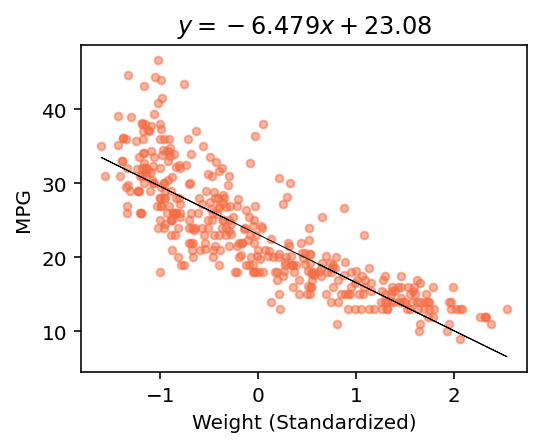

In [13]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

show(m, b, X=X, Y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

Let's create a generic training function for given model and a new show function.

In [14]:
def mshow(model, X=df_cars.WGT, Y=df_cars.MPG):
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, Y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    plt.show()

In [15]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - Y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - Y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

### Without nonlinearity

Epoch    0 MSE loss      600.717 MAE    23.23
Epoch   10 MSE loss       76.845 MAE     7.40
Epoch   20 MSE loss       22.614 MAE     3.49
Epoch   30 MSE loss       19.502 MAE     3.46
Epoch   40 MSE loss       19.218 MAE     3.36
Epoch   50 MSE loss       19.123 MAE     3.25
Epoch   60 MSE loss       18.846 MAE     3.34
Epoch   70 MSE loss       18.750 MAE     3.26
Epoch   80 MSE loss       18.699 MAE     3.30
Epoch   90 MSE loss       18.679 MAE     3.28
Epoch  100 MSE loss       18.679 MAE     3.27
LAST       MSE loss       18.679 MAE     3.27


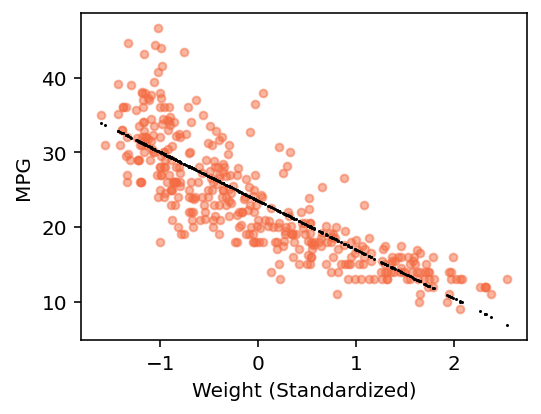

In [22]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, Y=df_cars.MPG)

### With ReLU nonlinearity

Epoch    0 MSE loss      629.533 MAE    23.79
Epoch   10 MSE loss       18.782 MAE     3.36
Epoch   20 MSE loss       19.047 MAE     3.38
Epoch   30 MSE loss       20.363 MAE     3.32
Epoch   40 MSE loss       18.968 MAE     3.34
Epoch   50 MSE loss       18.248 MAE     3.18
Epoch   60 MSE loss       18.324 MAE     3.16
Epoch   70 MSE loss       18.092 MAE     3.16
Epoch   80 MSE loss       17.986 MAE     3.18
Epoch   90 MSE loss       17.909 MAE     3.14
Epoch  100 MSE loss       17.851 MAE     3.14
LAST       MSE loss       17.851 MAE     3.14


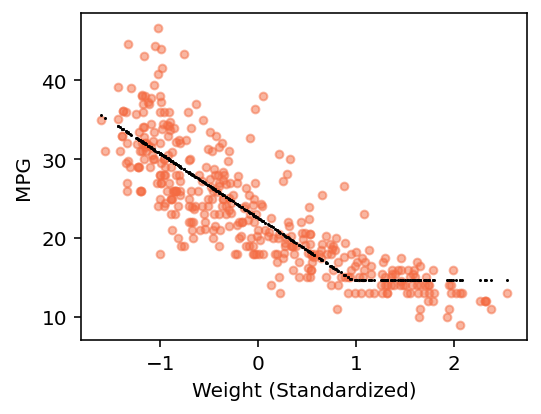

In [52]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),     # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, Y=df_cars.MPG)

### With tanh nonlinearity

Epoch    0 MSE loss      586.444 MAE    22.89
Epoch   10 MSE loss       47.376 MAE     5.87
Epoch   20 MSE loss       37.536 MAE     4.84
Epoch   30 MSE loss       34.465 MAE     4.64
Epoch   40 MSE loss       27.586 MAE     4.06
Epoch   50 MSE loss       27.302 MAE     4.09
Epoch   60 MSE loss       26.801 MAE     4.04
Epoch   70 MSE loss       26.568 MAE     4.00
Epoch   80 MSE loss       26.413 MAE     4.00
Epoch   90 MSE loss       26.419 MAE     4.01
Epoch  100 MSE loss       26.397 MAE     3.99
LAST       MSE loss       26.397 MAE     3.99


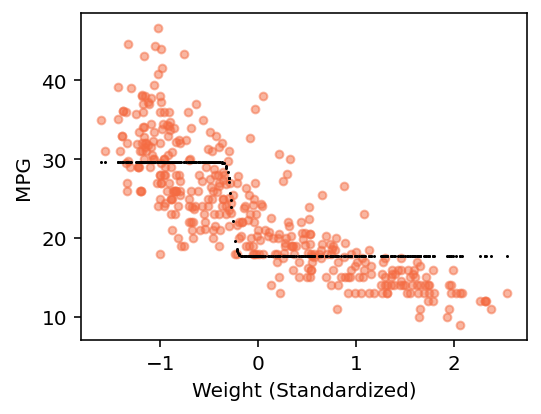

In [54]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Tanh(),       # gives smooth step function shape
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, Y=df_cars.MPG)

### With logistic function (sigmoid) nonlinearity

Epoch    0 MSE loss      592.082 MAE    23.08
Epoch   10 MSE loss      234.548 MAE    14.34
Epoch   20 MSE loss      135.312 MAE    10.01
Epoch   30 MSE loss       70.187 MAE     7.23
Epoch   40 MSE loss       45.042 MAE     5.63
Epoch   50 MSE loss       36.953 MAE     5.07
Epoch   60 MSE loss       32.740 MAE     4.67
Epoch   70 MSE loss       31.525 MAE     4.50
Epoch   80 MSE loss       31.766 MAE     4.47
Epoch   90 MSE loss       31.515 MAE     4.50
Epoch  100 MSE loss       31.543 MAE     4.52
LAST       MSE loss       31.543 MAE     4.52


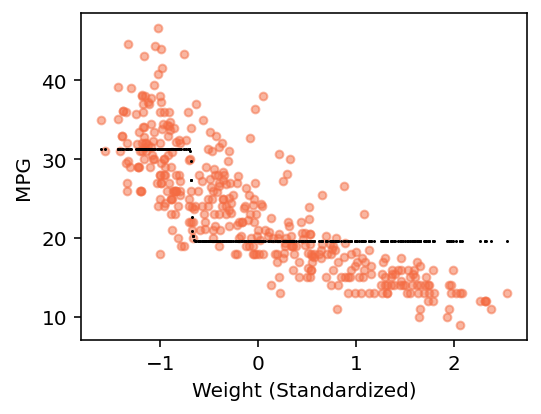

In [61]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=35, nepochs=100)

mshow(model, X=X, Y=df_cars.MPG)

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      608.428 MAE    23.46
Epoch  200 MSE loss       16.182 MAE     2.97
Epoch  400 MSE loss       16.463 MAE     2.94
Epoch  600 MSE loss       16.150 MAE     2.96
Epoch  800 MSE loss       17.167 MAE     3.11
Epoch 1000 MSE loss       16.502 MAE     3.01
Epoch 1200 MSE loss       16.679 MAE     3.08
Epoch 1400 MSE loss       18.668 MAE     3.14
Epoch 1600 MSE loss       16.570 MAE     2.98
Epoch 1800 MSE loss       16.212 MAE     2.97
Epoch 2000 MSE loss       16.773 MAE     3.11
LAST       MSE loss       16.773 MAE     3.11


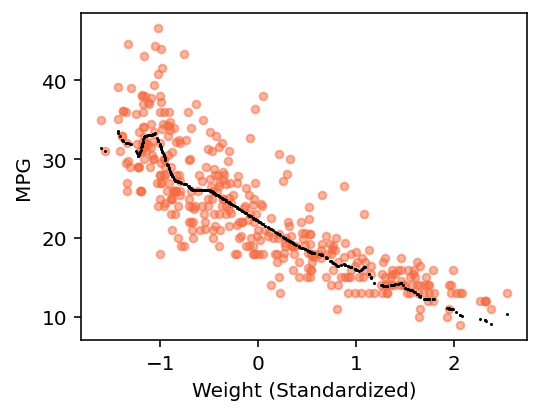

In [19]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model)

mshow(model, X=X, Y=df_cars.MPG)

Epoch    0 MSE loss      591.613 MAE    23.16
Epoch  200 MSE loss       17.064 MAE     3.02
Epoch  400 MSE loss       16.951 MAE     3.01
Epoch  600 MSE loss       17.067 MAE     3.01
Epoch  800 MSE loss       16.992 MAE     3.01
Epoch 1000 MSE loss       16.895 MAE     3.01
Epoch 1200 MSE loss       16.834 MAE     3.00
Epoch 1400 MSE loss       93.022 MAE     8.35
Epoch 1600 MSE loss       16.070 MAE     2.94
Epoch 1800 MSE loss       15.935 MAE     2.93
Epoch 2000 MSE loss       15.871 MAE     2.93
LAST       MSE loss       15.871 MAE     2.93


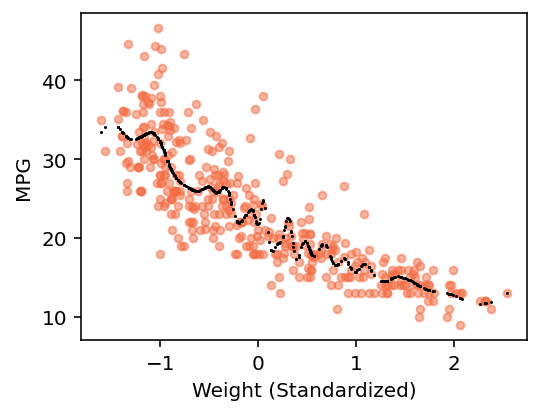

In [20]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Tanh(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model)

mshow(model, X=X, Y=df_cars.MPG)